In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import yfinance as yf
import statsmodels.tsa.stattools
import pandas as pd
import seaborn as sns
from tqdm import tqdm

[]

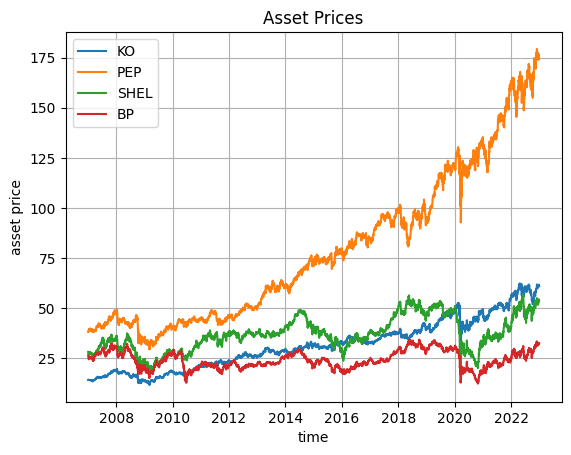

In [3]:
# Here we extract the closing prices and plot them for a set of assets
symbols = ['KO', 'PEP', 'SHEL', 'BP']
histories = [yf.Ticker(symbols[i]).history(interval='1d', start='2007-01-01', end='2023-01-01')[['Close']] for i in range(len(symbols))]
fig, ax = plt.subplots()
for i in range(len(histories)):
    ax.plot(histories[i]['Close'], label=symbols[i])
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('asset price')
ax.set_title('Asset Prices')
plt.legend()
plt.plot()

In [4]:
# Let's collect the data in a single dataframe
data = pd.concat(histories, axis=1)
data.columns = symbols

# if successive log-price ratios are desired
# data = pd.DataFrame(np.diff(np.log(data.to_numpy()), n=1, axis=0), columns=symbols)

data

,KO,PEP,SHEL,BP
Date,,,,
2007-01-03 00:00:00-05:00,14.311193,38.287125,28.286558,26.322447
2007-01-04 00:00:00-05:00,14.317087,38.549622,27.832481,25.975374
2007-01-05 00:00:00-05:00,14.216926,38.427540,27.321642,25.919519
2007-01-08 00:00:00-05:00,14.308247,38.512985,27.082457,25.648235
2007-01-09 00:00:00-05:00,14.320032,38.671711,26.972988,24.910185
...,...,...,...,...
2022-12-23 00:00:00-05:00,61.377171,175.832001,54.424831,32.682533
2022-12-27 00:00:00-05:00,61.752239,176.613434,54.509602,32.710537
2022-12-28 00:00:00-05:00,61.136734,175.339981,53.275669,32.281120


<Axes: xlabel='Date'>

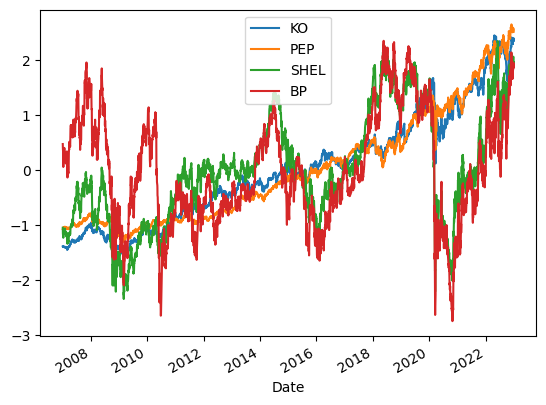

In [5]:
# Now we need to standardize the dataset
means = data.mean(axis=0)
stds = data.std(axis=0)
centered_data = (data-means)/stds
centered_data.plot()

In [6]:
# Now we can compute a square-sum "correlation" type quantity for each pair:
squared_sums = np.zeros(shape=(len(symbols), len(symbols)))
for i in range(len(symbols)):
    for j in range(len(symbols)):
        squared_sums[i, j] = np.square(centered_data.iloc[:, i].to_numpy()-centered_data.iloc[:, j].to_numpy()).sum()
squared_sums

array([[   0.        ,  165.58175654, 2920.98151333, 6181.69619691],
       [ 165.58175654,    0.        , 3562.41979921, 6182.86793247],
       [2920.98151333, 3562.41979921,    0.        , 2271.20151941],
       [6181.69619691, 6182.86793247, 2271.20151941,    0.        ]])

<Axes: >

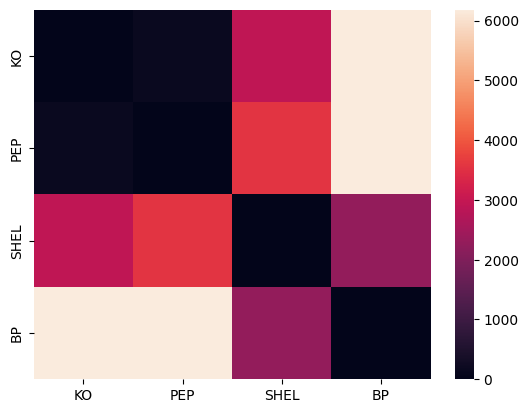

In [7]:
sns.heatmap(squared_sums, xticklabels=symbols, yticklabels=symbols)

[ 165.58175654 2920.98151333 6181.69619691 3562.41979921 6182.86793247
 2271.20151941]


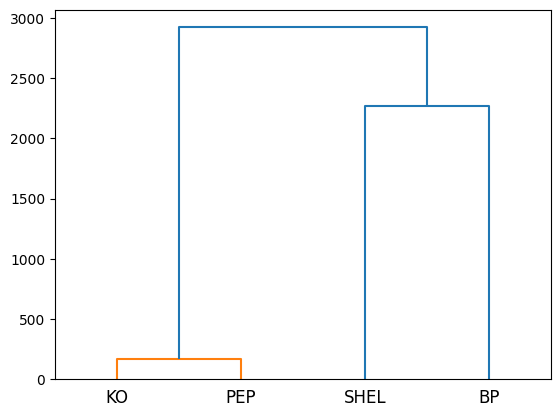

In [8]:
# It would make sense for small values of this sum of differential squares
# to indicate strong correlations between the two assets

# Clearly in this example, Coca Cola (KO) and Pepsi (PEP) have the potential to
# form a good pair in our pair trading strategy

# We can receive further affirmation through a dendrogram to cluster based on these "distances"
condensed_distances = sp.spatial.distance.squareform(squared_sums)
print(condensed_distances)
fig, ax = plt.subplots()
linkage = sp.cluster.hierarchy.linkage(condensed_distances)
dendrogram = sp.cluster.hierarchy.dendrogram(linkage, ax=ax, labels=symbols)

In [9]:
# Let's just go with KO and PEP nonetheless

Text(0.5, 1.0, 'Pair Relationship')

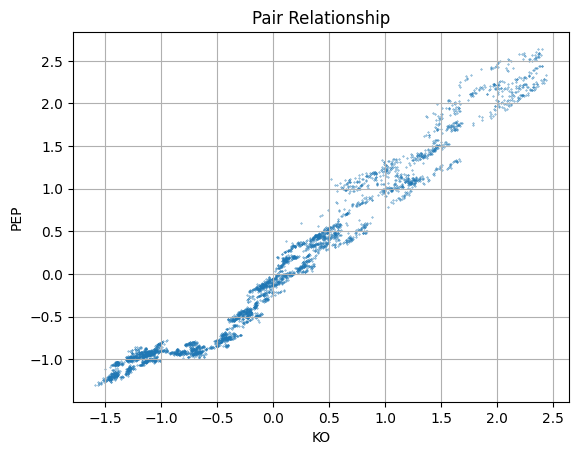

In [10]:
# Let's visualise the relationship between the prices of PEP and KO:
fig, ax = plt.subplots()
ax.scatter(centered_data['KO'], centered_data['PEP'], s=0.1)
ax.grid(True)
ax.set_xlabel('KO')
ax.set_ylabel('PEP')
ax.set_title('Pair Relationship')

In [11]:
# Fit the pair using ordinary least-squares regression 

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
model = sm.OLS(centered_data['PEP'], sm.add_constant(centered_data['KO'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PEP   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 9.490e+04
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:34:55   Log-Likelihood:                 733.13
No. Observations:                4028   AIC:                            -1462.
Df Residuals:                    4026   BIC:                            -1450.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-16      0.003   8.73e-14      1.000      -0.006       0.006
KO             0.9794      0.003    308.066      0.000       0.973       0.986
==============================================================================
Omnibus:                      222.013   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.522
Skew:                           0.114   Prob(JB):                     1.34e-20
Kurtosis:                       2.297   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Clearly, the regression is extraordinary, with the t-statistic p-value being 0.000 (to 3 dp) for the PEP-KO regressor and the 
# Now all we need to do is check whether the quantity PEP - beta_1*KO - beta_0 is indeed stationary (which would be true if the regression premise of 
# PEP = beta_0 + beta_1*KO + epsilon where epsilon~N(0, sigma^2) had been true)

# We use the Augmented Dickey-Fuller (ADF) test to test the difference (spread) for stationarity

beta_0 = model.params[0]
beta_1 = model.params[1]
spread = centered_data['PEP'] - beta_1*centered_data['KO'] - beta_0

from statsmodels.tsa.stattools import adfuller
stationarity_results = adfuller(spread)
test_statistic = stationarity_results[0]
p_value = stationarity_results[1]
print(f"p-value = {p_value}")

p-value = 0.017147034285200372


Text(0.5, 1.0, 'Pair Relationship')

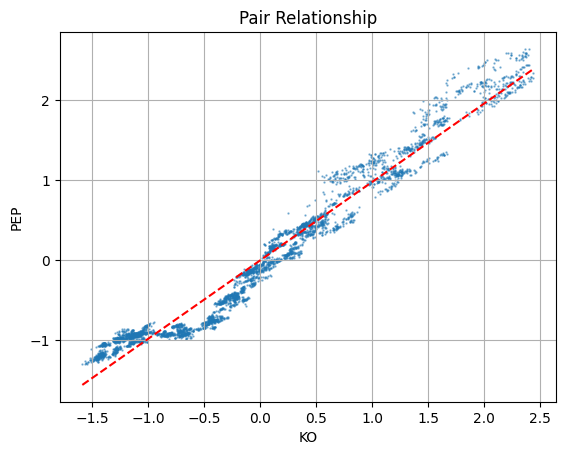

In [13]:
# Let's examine the linear fit

x = np.linspace(np.percentile(centered_data['KO'], 0), np.percentile(centered_data['KO'], 100), 100) 
y = beta_0 + beta_1*x

fig, ax = plt.subplots()
ax.scatter(centered_data['KO'], centered_data['PEP'], s=0.5, alpha=0.5)
ax.plot(x, y, c='red', alpha=1, ls='--')
ax.grid(True)
ax.set_xlabel('KO')
ax.set_ylabel('PEP')
ax.set_title('Pair Relationship')

In [14]:
# We can conclude that stationarity of the pair-spread is accepted at the 2% level of significance

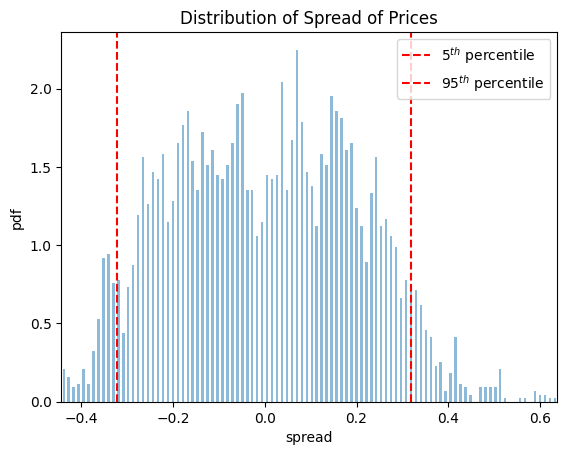

In [15]:
# Now let's visualise a histogram of the spread
fig, ax = plt.subplots()
ax.hist(spread, bins=100, rwidth=0.5, alpha=0.5, density=True)
ax.axvline(np.percentile(spread, 5), label="$5^{th}$ percentile", c='red', ls='--')
ax.axvline(np.percentile(spread, 95), label="$95^{th}$ percentile", c='red', ls='--')
ax.set_xlim(np.percentile(spread, 0), np.percentile(spread, 100))
ax.set_xlabel('spread')
ax.set_ylabel('pdf')
ax.set_title('Distribution of Spread of Prices')
plt.legend()
plt.show()

In [16]:
# Now we are interested in an entry position for a trade. Assuming the spread to be normally distributed,
# we decide to enter the trade at a z-score of 0.7518 and exit the trade at the mean (z-score=0)

In [17]:
# However in order to compute the z-score we need to know the mean and variance. Let's compute the mean and variance  by fitting the spread
# to an AR(1) model and comparing it to an Ornstein-Uhlenbeck process whose discretised version takes the same AR(1) form

# mu is the reversion strength of the OU process and theta is the long term mean to which reversion occurs
# sigma is another parameter in the OU process equation

dt = 1 # days

from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(spread, lags=1, trend='n', seasonal=False, exog=np.ones(len(spread))).fit()
# print(model.summary())
alpha = model.params[1]
beta = model.params[0]
mu = -np.log(beta)/dt
theta = alpha/(1-beta)
sigma = np.std(np.array(spread[1:])-alpha-beta*np.array(spread[:-1]))*np.sqrt(2*mu/(1-beta**2))
print("mu = %.3f" % mu)
print("theta = %.3f" % theta)
print("sigma = %4.3f" % sigma)

mu = 0.006
theta = -0.003
sigma = 0.022


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


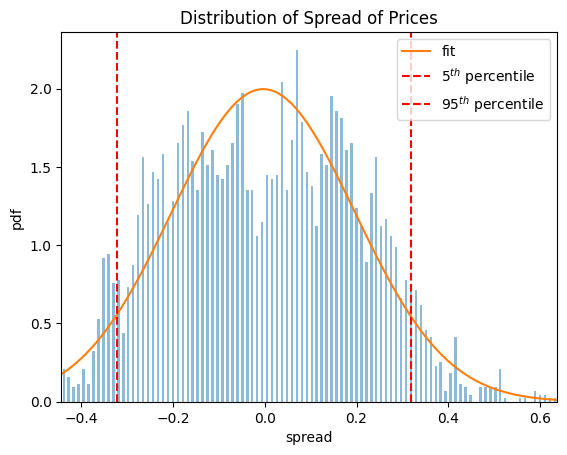

In [18]:
# Now let's visualise the spread fit as if it were a normal distribution with the mean and standard deviation of an Ornstein Uhlenbeck process

from scipy.stats import norm
x = np.linspace(np.percentile(spread, 0), np.percentile(spread, 100), 100)
y = norm.pdf(x, theta, scale=sigma/np.sqrt(2*mu))

fig, ax = plt.subplots()
ax.hist(spread, bins=100, rwidth=0.5, alpha=0.5, density=True)
ax.plot(x, y, label='fit')
ax.axvline(np.percentile(spread, 5), label="$5^{th}$ percentile", c='red', ls='--')
ax.axvline(np.percentile(spread, 95), label="$95^{th}$ percentile", c='red', ls='--')
ax.set_xlim(np.percentile(spread, 0), np.percentile(spread, 100))
ax.set_xlabel('spread')
ax.set_ylabel('pdf')
ax.set_title('Distribution of Spread of Prices')
plt.legend()
plt.show()

In [19]:
# This looks like a good fit! Now let's examine the distribution of half lives to determine the trading window we should care about
# We will use the Ornstein Uhlenbeck parameters obtained by fitting the spread and generate new values by sampling an OU process. This is parametric bootstrapping.

def sample_ou_process(theta, sigma, mu, dt, x):
    x = theta + (x-theta)*np.exp(-mu*dt) + (sigma/np.sqrt(2*mu))*(np.sqrt(1-np.exp(-2*mu*dt)))*np.random.normal()
    return x

mus = []
for i in range(1000):
    sequence = []
    x = spread[0]
    sequence.append(x)
    for j in range(len(spread)-1):
        x = sample_ou_process(theta, sigma, mu, dt, x)
        sequence.append(x)
    sequence = np.array(sequence)

    # Now fit this generated OU sequence as an AR(1) process
    model = AutoReg(sequence, lags=1, trend='n', seasonal=False, exog=np.ones(len(sequence))).fit()
    alpha_temp = model.params[1]
    beta_temp = model.params[0]
    mu_temp = -np.log(beta_temp)/dt
    mus.append(mu_temp)

taus = np.log(2)/mus # half life distribution

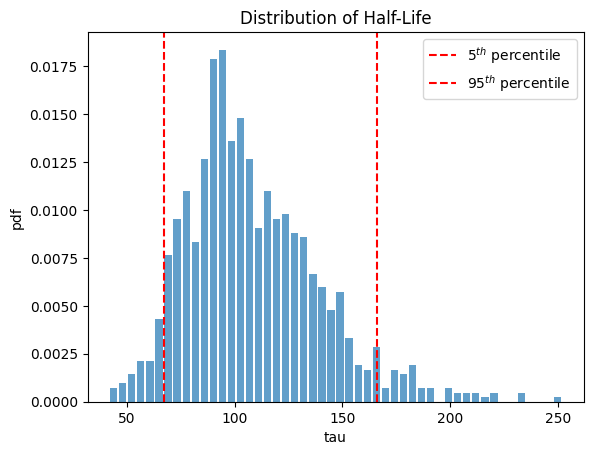

In [20]:
# Visualize the distribution of half-lives

fig, ax = plt.subplots()
ax.hist(taus, density=True, bins=50, rwidth=0.8, alpha=0.7)
ax.set_xlabel('tau')
ax.set_ylabel('pdf')
ax.set_title('Distribution of Half-Life')
ax.axvline(np.percentile(taus, 5), label='$5^{th}$ percentile', c='red', ls='--')
ax.axvline(np.percentile(taus, 95), label='$95^{th}$ percentile', c='red', ls='--')
plt.legend()
plt.show()


In [21]:
# Clearly the holding time lasts over a long period for this pair-spread (~100 days) and has a large variance. 
# We keep this distribution in mind when choosing rolling windows

In [33]:
# Now we build our backtesting strategy with a rolling window of specified size

# the pair of assets being traded
asset_a = 'KO'
asset_b = 'PEP'

# the entry and exit z-statistics
z_entry = 0.7518
z_exit = 0
window = 400 # the number of look-back days for statistics

# store the prices in a new data frame
pairs_data = data[[asset_a, asset_b]]

# information used t0 make the trading decision and signal changes
prev_z_score = 0 
position = 0
signal = 0
z_scores = []
positions = []

# the number of each stock's shares held
shares_a = 0
shares_b = 0
shares_a_history = []
shares_b_history = []

# the total value held
portfolio = 0
portfolio_history = []

min_order = 1 # minimum number of shares that must be bought

hedge_ratios=[] # a list of the ratio of shares of asset_b and asset_a at each timestep

def close_positions():
    global portfolio, shares_a, shares_b, position
    portfolio += shares_a*current_prices[asset_a] + shares_b*current_prices[asset_b]
    shares_a = 0
    shares_b = 0
    position = 0

for i in tqdm(range(window, len(spread))):
    moving_mean = np.mean(pairs_data.iloc[i-window:i], axis=0) # compute rolling mean
    moving_std = np.std(pairs_data.iloc[i-window:i], axis=0) # compute rolling standard deviation
    standardized_prices = (pairs_data.iloc[i-window:i]-moving_mean)/moving_std # standardize the prices
    moving_model = sm.OLS(standardized_prices[asset_b], sm.add_constant(standardized_prices[asset_a])).fit() # perform OLS linear regression on the standardized asset prices 
    moving_beta_0 = moving_model.params[0] # intercept
    moving_beta_1 = moving_model.params[1] # slope
    # Retest p_value for stationarity

    # stationarity_results = adfuller(spread)
    # test_statistic = stationarity_results[0]
    # p_value = stationarity_results[1]
    # if p_value > 0.02:
    #     print(f"Not stationary at i={i}")

    moving_spread = np.array(standardized_prices[asset_b])-moving_beta_1*np.array(standardized_prices[asset_a])-moving_beta_0 # compute moving spread
    moving_model = AutoReg(moving_spread, lags=1, trend='n', seasonal=False, exog=np.ones(len(moving_spread))).fit() # fit an autoregression to the window of spread data
    moving_alpha = moving_model.params[1] # constant
    moving_beta = moving_model.params[0] # lag=1 coefficient
    moving_mu = -np.log(moving_beta)/dt # window's mu for OU process
    moving_theta = moving_alpha/(1-moving_beta) # window's theta for OU process
    moving_sigma = np.std(np.array(moving_spread[1:])-moving_alpha-moving_beta*np.array(moving_spread[:-1]))*np.sqrt(2*moving_mu/(1-moving_beta**2)) # window's sigma for OU process

    current_prices = pairs_data.iloc[i] # latest prices
    current_standardized_price = ((current_prices-moving_mean)/moving_std) # latest prices standardized
    current_spread = current_standardized_price[asset_b]-moving_beta_1*current_standardized_price[asset_a]-moving_beta_0 # latest spread
    z_score = (current_spread-moving_theta)/(moving_sigma/np.sqrt(2*moving_mu)) # latest z-score
    z_scores.append(z_score)

    # Now generate the trading signals
    if prev_z_score < z_entry and z_score > z_entry and position > -1: # if pair is overbought
        close_positions()
        signal = -1
        position = -1
    elif prev_z_score > -z_entry and z_score < -z_entry and position < 1: # if pair is oversold
        close_positions()
        signal = 1 # long the pair
        position = 1
    elif prev_z_score > z_exit and z_score < z_exit: # if exiting the overbought region
        close_positions()
        signal = 0
        position = 0
    elif prev_z_score < -z_exit and z_score > -z_exit: # if exiting the underbought region
        close_positions()
        signal = 0
        position = 0
    else:
        signal = 0

    # Now execute the trades
    hedge_ratio = (moving_std[asset_a]/moving_std[asset_b])/moving_beta_1 # compute the hedge ratio (asset_b/asset_a ratio of shares to trade)
    shares_a -= signal*min_order # short asset_a for positive delta
    shares_b += hedge_ratio*signal*min_order # long asset_b for positive delta
    portfolio -= (hedge_ratio*signal*min_order*current_prices[asset_b] - signal*min_order*current_prices[asset_a]) # update portfolio according to shares bought and sold

    # update z_score 
    prev_z_score = z_score

    shares_a_history.append(shares_a)
    shares_b_history.append(shares_b)
    positions.append(position)
    portfolio_history.append(portfolio)
    hedge_ratios.append(hedge_ratio)

# close all positions
close_positions()
position = 0
positions.append(position)

# convert to numpy arrays for convenience
z_scores = np.array(z_scores)
positions = np.array(positions)
portfolio_history = np.array(portfolio_history)
hedge_ratios = np.array(hedge_ratios)

100%|██████████| 3628/3628 [00:12<00:00, 286.09it/s]


In [34]:
# Generate the trading signal triangles based on when the trading signal changes to +1 or -1
buy_signals = []
sell_signals = []
if positions[0] == 1:
    buy_signals.append(0)
elif positions[0] == -1:
    sell_signals.append(0)
for i in range(1, len(positions)):
    if positions[i] == 1 and positions[i-1] < 1:
        buy_signals.append(i)
    if positions[i] == -1 and positions[i-1] > -1:
        sell_signals.append(i)
buy_signals = np.array(buy_signals)
sell_signals = np.array(sell_signals)

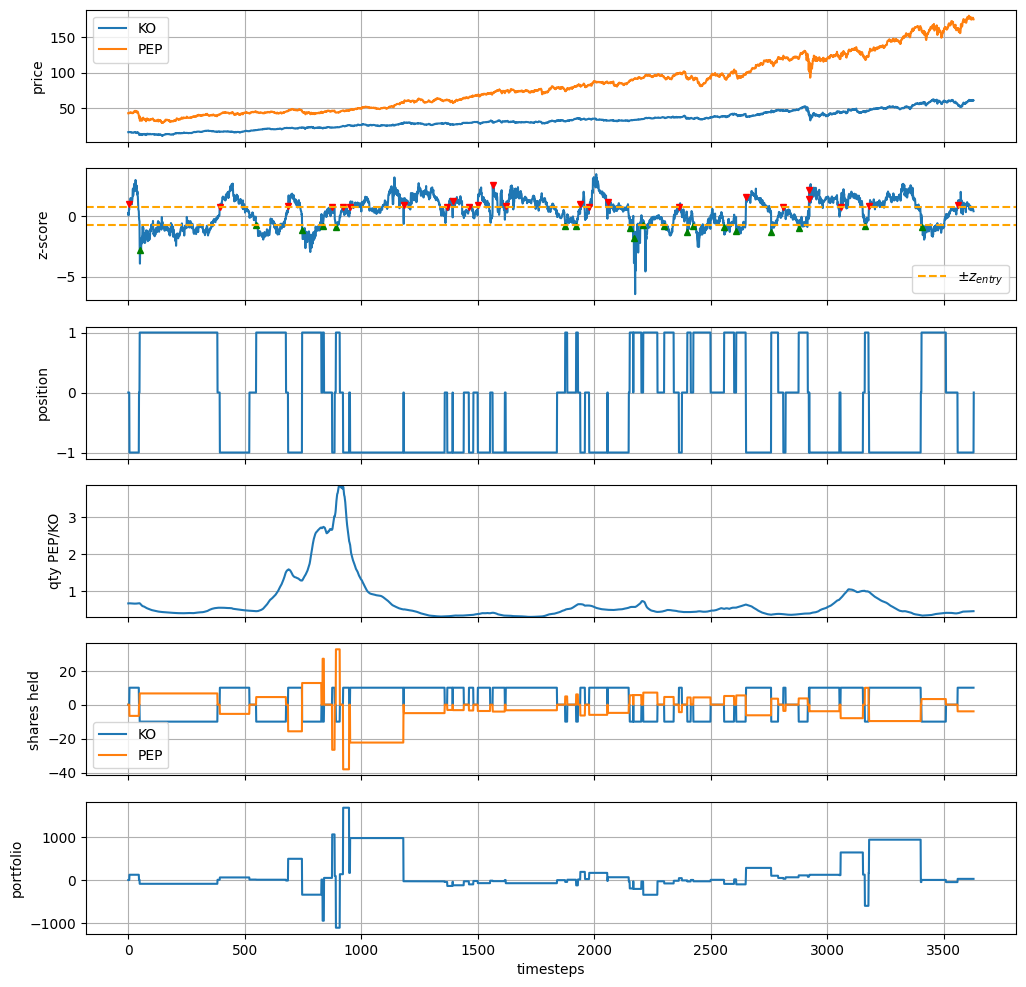

profit = 27.067895984498477


<Figure size 640x480 with 0 Axes>

In [35]:
# Visualise the trade

fig, axs = plt.subplots(nrows = 6, ncols = 1, figsize=(12, 12), sharex=True)

axs[0].plot(np.array(pairs_data.iloc[window:][asset_a]), label=f'{asset_a}')
axs[0].plot(np.array(pairs_data.iloc[window:][asset_b]), label=f'{asset_b}')
axs[0].set_ylabel('price')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(z_scores)
axs[1].plot(buy_signals, z_scores[buy_signals], marker='^', c='green', ls='', markersize=4)
axs[1].plot(sell_signals, z_scores[sell_signals], marker='v', c='red', ls='', markersize=4)
axs[1].axhline(z_entry, c='orange', ls='--', label='$\pm z_{entry}$')
axs[1].axhline(-z_entry, c='orange', ls='--')
axs[1].legend(loc='lower right')
axs[1].set_ylabel('z-score')
axs[1].grid(True)

axs[2].plot(positions)
axs[2].set_ylabel('position')
axs[2].grid(True)

axs[3].plot(hedge_ratios)
axs[3].set_ylabel(f'qty {asset_b}/{asset_a}')
axs[3].set_ylim([np.min(hedge_ratios), np.max(hedge_ratios)])
axs[3].grid(True)

axs[4].plot(shares_a_history, label=asset_a)
axs[4].plot(shares_b_history, label=asset_b)
axs[4].grid(True)
axs[4].set_ylabel('shares held')
axs[4].legend()

axs[5].plot(portfolio_history)
axs[5].set_ylabel('portfolio')
axs[5].grid(True)
axs[5].set_xlabel('timesteps')

plt.show()
plt.tight_layout()

print(f"profit = {portfolio_history[-1]}")

